In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import kagglehub


import tarfile
import shutil
import scipy.io
import random
from pathlib import Path
from sklearn.model_selection import train_test_split




import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashfaqsyed/102-flower-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.35G/2.35G [01:16<00:00, 33.2MB/s]

Extracting files...


Path to dataset files: /home/maiko/.cache/kagglehub/datasets/ashfaqsyed/102-flower-dataset/versions/1


In [3]:
target_dir = "./data/flowers"

!mkdir -p {target_dir}
!mv {path}/* {target_dir}/

print(f"Files moved to: {target_dir}")


Files moved to: ./data/flowers


In [6]:

dataset_archive = "./data/flowers/102flowers.tgz"
label_file = "./data/flowers/imagelabels.mat"
extracted_dir = "./data/flowers/jpg"  # the folder inside the .tgz
output_dir = "./data/flowers"

# 1. Extract the .tgz archive
with tarfile.open(dataset_archive, "r:gz") as tar:
    tar.extractall(path=output_dir)

# 2. Load labels from .mat
labels_data = scipy.io.loadmat(label_file)
labels = labels_data['labels'][0]  # Shape (8189,)

# 3. Collect all image filenames
image_files = sorted(Path(extracted_dir).glob("*.jpg"))  # Sorted by file name
assert len(image_files) == len(labels), "Mismatch in images and labels count"

# 4. Create label to filenames mapping
label_to_files = {}
for img_path, label in zip(image_files, labels):
    class_name = f"class_{label:03d}"
    label_to_files.setdefault(class_name, []).append(img_path)

# 5. Split and move files into train/val/test
def split_and_copy(label_to_files, base_dir, train_ratio=0.7, val_ratio=0.15):
    for class_name, files in label_to_files.items():
        random.shuffle(files)
        n = len(files)
        train_end = int(train_ratio * n)
        val_end = train_end + int(val_ratio * n)

        splits = {
            "train": files[:train_end],
            "val": files[train_end:val_end],
            "test": files[val_end:]
        }

        for split, split_files in splits.items():
            split_dir = Path(base_dir) / split / class_name
            split_dir.mkdir(parents=True, exist_ok=True)

            for file in split_files:
                shutil.copy(file, split_dir / file.name)

split_and_copy(label_to_files, output_dir)

print("Dataset organized into train/val/test folders successfully.")


Dataset organized into train/val/test folders successfully.


In [7]:
import os

# List files and folders in the target directory
for root, dirs, files in os.walk(target_dir):
    print(f"\n📁 {root}")
    for d in dirs:
        print(f"  └── 📂 {d}")
    for f in files[:5]: 
        print(f"  └── 📄 {f}")



📁 ./data/flowers
  └── 📂 jpg
  └── 📂 val
  └── 📂 train
  └── 📂 test
  └── 📄 102flowers.tgz
  └── 📄 imagelabels.mat
  └── 📄 distancematrices102.mat
  └── 📄 setid.mat
  └── 📄 102segmentations.tgz

📁 ./data/flowers/jpg
  └── 📄 image_01404.jpg
  └── 📄 image_05029.jpg
  └── 📄 image_07831.jpg
  └── 📄 image_00990.jpg
  └── 📄 image_05751.jpg

📁 ./data/flowers/val
  └── 📂 class_029
  └── 📂 class_027
  └── 📂 class_013
  └── 📂 class_001
  └── 📂 class_024
  └── 📂 class_102
  └── 📂 class_032
  └── 📂 class_078
  └── 📂 class_054
  └── 📂 class_093
  └── 📂 class_047
  └── 📂 class_007
  └── 📂 class_071
  └── 📂 class_030
  └── 📂 class_044
  └── 📂 class_086
  └── 📂 class_083
  └── 📂 class_080
  └── 📂 class_070
  └── 📂 class_046
  └── 📂 class_049
  └── 📂 class_088
  └── 📂 class_063
  └── 📂 class_012
  └── 📂 class_066
  └── 📂 class_031
  └── 📂 class_056
  └── 📂 class_068
  └── 📂 class_101
  └── 📂 class_079
  └── 📂 class_091
  └── 📂 class_011
  └── 📂 class_099
  └── 📂 class_022
  └── 📂 class_003
  └── 📂 cla

In [9]:
# Setup directories
data_dir = "./data/flowers"
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print paths to verify
print(f"Training directory: {train_dir}")
print(f"Validation directory: {validation_dir}")
print(f"Test directory: {test_dir}")

# 1. Enhanced Data Augmentation for more robust feature learning
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Many flowers look similar upside down
    brightness_range=[0.7, 1.3],
    fill_mode='reflect'  # Better for natural images
)

# Validation generator (no augmentation, just preprocessing)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Test generator (no augmentation, just preprocessing)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Set up parameters
img_height, img_width = 299, 299  # InceptionV3 input size
batch_size = 32

# Create training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Print number of classes and samples
print(f"Number of classes: {train_generator.num_classes}")
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

# Class indices mapping for reference
class_indices = train_generator.class_indices
print("\nClass mapping sample (first 10 classes):")
for i, (class_name, index) in enumerate(list(class_indices.items())[:10]):
    print(f"{index}: {class_name}")

Training directory: ./data/flowers/train
Validation directory: ./data/flowers/val
Test directory: ./data/flowers/test
Found 5687 images belonging to 102 classes.
Found 1185 images belonging to 102 classes.
Found 1317 images belonging to 102 classes.
Number of classes: 102
Number of training samples: 5687
Number of validation samples: 1185
Number of test samples: 1317

Class mapping sample (first 10 classes):
0: class_001
1: class_002
2: class_003
3: class_004
4: class_005
5: class_006
6: class_007
7: class_008
8: class_009
9: class_010


In [14]:
# 2. Feature Visualization Functions
def preprocess_image(img_path, target_size=(299, 299)):
    """Load and preprocess an image for InceptionV3"""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def deprocess_image(img):
    """Convert preprocessed image back to displayable format"""
    img = img.reshape(img.shape[1:])
    img = (img + 1.0) * 127.5
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# 3. Feature Diversity Loss - Encourages diverse feature activations in middle layers
def feature_diversity_loss(layer_output):
    """Loss function to encourage diverse feature activations"""
    # Calculate standard deviation across feature maps
    feature_std = K.std(layer_output, axis=-1)
    # Encourage higher standard deviation (more diverse features)
    return -K.mean(feature_std)

# 4. Class Activation Mapping
def generate_gradcam(model, img_array, layer_name, class_idx):
    """Generate Grad-CAM visualization for a specific class"""
    # Create a model that maps the input image to the activations of the specified layer and predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
        
    # Extract gradients
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0, 1))
    
    # Create a weighted combination of filters
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    
    # Process CAM
    cam = tf.maximum(cam, 0)
    cam = cam / tf.math.reduce_max(cam)
    cam = cam.numpy()
    return cam

def overlay_gradcam(img_path, cam, target_size=(299, 299)):
    """Overlay Grad-CAM heatmap on original image"""
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    
    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    overlayed = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
    return overlayed

# 5. Custom Callback for Tracking Layer Activations
class FeatureVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, layer_names, output_dir='feature_viz', freq=2):
        super(FeatureVisualizationCallback, self).__init__()
        self.validation_data = validation_data
        self.layer_names = layer_names
        self.output_dir = output_dir
        self.freq = freq
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq != 0:
            return
            
        # Get a sample batch
        x_val, y_val = next(self.validation_data)
        
        # Create a model to output activations for each layer
        layer_outputs = [self.model.get_layer(name).output for name in self.layer_names]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        
        # Get activations
        activations = activation_model.predict(x_val)
        
        # Visualize activations for each layer
        for i, layer_name in enumerate(self.layer_names):
            # Create output directory for this layer
            layer_dir = os.path.join(self.output_dir, f"{layer_name}_epoch{epoch+1}")
            if not os.path.exists(layer_dir):
                os.makedirs(layer_dir)
                
            # Get layer activations
            layer_activation = activations[i]
            
            # Visualize feature maps
            plt.figure(figsize=(16, 16))
            features_per_row = 8
            n_features = min(64, layer_activation.shape[-1])
            n_rows = n_features // features_per_row
            
            for j in range(n_features):
                plt.subplot(n_rows, features_per_row, j+1)
                plt.imshow(layer_activation[0, :, :, j], cmap='viridis')
                plt.axis('off')
                
            plt.tight_layout()
            plt.savefig(os.path.join(layer_dir, f"feature_maps.png"))
            plt.close()
            
            # For the first sample image, also generate Grad-CAM for the top predicted class
            if i == len(self.layer_names) - 1:  # Only do this for the last layer
                predicted_class = np.argmax(self.model.predict(x_val[0:1]))
                cam = generate_gradcam(self.model, x_val[0:1], layer_name, predicted_class)
                
                # Reshape CAM to image dimensions
                cam_resized = cv2.resize(cam, (img_width, img_height))
                
                # Save CAM heatmap
                plt.figure(figsize=(8, 8))
                plt.imshow(cam_resized)
                plt.colorbar()
                plt.tight_layout()
                plt.savefig(os.path.join(layer_dir, f"gradcam_class{predicted_class}.png"))
                plt.close()

# 6. DeepDream Visualization Callback
def deepdream(model, img_array, layer_name, iterations=20, step=0.01):
    """Create a DeepDream image by maximizing activations"""
    # Create a model that outputs the target layer's activations
    feature_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    # Define the loss (maximize activations)
    def calculate_loss(img):
        activation = feature_extractor(img)
        return -tf.reduce_mean(activation)
    
    # Gradient ascent step
    @tf.function
    def gradient_ascent_step(img, learning_rate):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = calculate_loss(img)
        
        # Calculate gradients
        grads = tape.gradient(loss, img)
        # Normalize gradients
        grads = tf.math.l2_normalize(grads)
        # Apply gradients
        img += learning_rate * grads
        return loss, img
    
    # Start with the input image
    dream_img = tf.convert_to_tensor(img_array)
    
    # Perform gradient ascent
    for i in range(iterations):
        loss, dream_img = gradient_ascent_step(dream_img, step)
    
    # Return the final image
    return deprocess_image(dream_img.numpy())

class DeepDreamVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, test_img_path, layers, output_dir='deepdream_viz', freq=5):
        super(DeepDreamVisualizationCallback, self).__init__()
        self.test_img = preprocess_image(test_img_path)
        self.layers = layers
        self.output_dir = output_dir
        self.freq = freq
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            # Save original image for reference
            original_img = image.load_img(test_img_path, target_size=(299, 299))
            original_img.save(os.path.join(output_dir, 'original_image.jpg'))
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq != 0:
            return
            
        epoch_dir = os.path.join(self.output_dir, f"epoch_{epoch+1}")
        if not os.path.exists(epoch_dir):
            os.makedirs(epoch_dir)
            
        for layer_name in self.layers:
            print(f"Generating DeepDream for layer {layer_name} at epoch {epoch+1}")
            try:
                # Generate DeepDream for this layer
                dream_img = deepdream(
                    self.model, 
                    self.test_img.copy(), 
                    layer_name,
                    iterations=15  # Keep it reasonably fast for monitoring
                )
                
                # Save visualization
                Image.fromarray(dream_img).save(os.path.join(epoch_dir, f"{layer_name}.jpg"))
            except Exception as e:
                print(f"Error generating DeepDream for layer {layer_name}: {e}")

In [15]:
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a final output layer with softmax for classification
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the main model
model = Model(inputs=base_model.input, outputs=predictions)

# Select a representative flower image for visualization
# You should replace this with an actual path to a flower image
sample_img_path = os.path.join(train_dir, os.listdir(train_dir)[0], os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
print(f"Using sample image for visualizations: {sample_img_path}")

# Setup callbacks
monitor_layers = ['mixed3', 'mixed5', 'mixed7', 'mixed9']

feature_viz_callback = FeatureVisualizationCallback(
    validation_generator,
    monitor_layers,
    output_dir='feature_viz',
    freq=2
)

deepdream_callback = DeepDreamVisualizationCallback(
    sample_img_path,
    monitor_layers,
    output_dir='deepdream_viz',
    freq=5
)

# Regular training callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'flower_model_checkpoint_{epoch:02d}.h5',
    save_best_only=True,
    monitor='val_accuracy'
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

callbacks = [
    feature_viz_callback,
    deepdream_callback,
    checkpoint_callback,
    reduce_lr_callback
]

# ----- TRAINING PROCESS -----

# STEP 1: Train only the top layers with all base model layers frozen
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("PHASE 1: Training top layers only...")
history_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5,
    callbacks=callbacks
)

# STEP 2: Progressive Layer Unfreezing - One block at a time
# Get all the mixed layer names to use as reference points
mixed_layers = [layer.name for layer in base_model.layers if 'mixed' in layer.name]
mixed_layers.sort()  # Sort in ascending order from bottom to top

histories = [history_1]  # Keep track of training history

# Define the progressive unfreezing schedule - starting from the top
unfreezing_schedule = [
    mixed_layers[-1],  # mixed10
    mixed_layers[-2],  # mixed9
    mixed_layers[-3],  # mixed8
    mixed_layers[-4],  # mixed7
]

# Create a model with feature diversity loss for mid-level layers
# We'll use 'mixed7' as our feature diversity target
feature_layer = base_model.get_layer('mixed7').output
aux_output = Lambda(lambda x: x, name='feature_layer')(feature_layer)

# Create a model with multiple outputs
model_with_aux = Model(
    inputs=base_model.input, 
    outputs=[predictions, aux_output]
)

# Learning rate schedule - decrease as we unfreeze deeper layers
lr_schedule = [5e-4, 2e-4, 1e-4, 5e-5]

# Progressively unfreeze layers and train
for phase, (target_layer, lr) in enumerate(zip(unfreezing_schedule, lr_schedule), start=2):
    print(f"\nPHASE {phase}: Unfreezing layers from {target_layer} onwards...")
    
    # Reset all layers to trainable
    for layer in base_model.layers:
        layer.trainable = True
    
    # Then freeze everything before the target layer
    target_idx = [i for i, layer in enumerate(base_model.layers) if layer.name == target_layer][0]
    for layer in base_model.layers[:target_idx]:
        layer.trainable = False
        
    # Count trainable parameters
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    print(f"Trainable parameters: {trainable_count:,}")
    print(f"Non-trainable parameters: {non_trainable_count:,}")
    
    # For the middle layers, use the feature diversity loss
    if phase == 4:  # When we're unfreezing mixed7
        print("Adding feature diversity loss for mid-level layers...")
        model = model_with_aux
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss={
                'dense': 'categorical_crossentropy',
                'feature_layer': feature_diversity_loss
            },
            loss_weights={
                'dense': 1.0,
                'feature_layer': 0.2  # Weight for the feature diversity loss
            },
            metrics={'dense': ['accuracy']}
        )
        
        # For this phase, fit with both outputs
        history_phase = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            epochs=5,
            callbacks=callbacks
        )
    else:
        # Standard training for other phases
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        history_phase = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            epochs=5,
            callbacks=callbacks
        )
    
    # Save history for plotting
    histories.append(history_phase)

# STEP 3: Final Fine-tuning Phase - All Layers
print("\nPHASE FINAL: Fine-tuning all layers with very low learning rate...")

# Make all layers trainable for final tuning
for layer in model.layers:
    layer.trainable = True

# Very low learning rate for final fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_final = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5,
    callbacks=callbacks
)

histories.append(history_final)

# Save the final fine-tuned model
model.save('flower_finetuned_inceptionv3_enhanced.h5')

# Function to plot combined training history
def plot_training_history(histories):
    # Combined histories
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    
    # Combine histories, accounting for multiple output model
    for history in histories:
        if 'accuracy' in history.history:
            acc.extend(history.history['accuracy'])
            val_acc.extend(history.history['val_accuracy'])
            loss.extend(history.history['loss'])
            val_loss.extend(history.history['val_loss'])
        elif 'dense_accuracy' in history.history:
            # For the model with multiple outputs
            acc.extend(history.history['dense_accuracy'])
            val_acc.extend(history.history['val_dense_accuracy'])
            loss.extend(history.history['loss'])
            val_loss.extend(history.history['val_loss'])
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=5, color='r', linestyle='--', label='Phase 1')
    plt.axvline(x=10, color='g', linestyle='--', label='Phase 2')
    plt.axvline(x=15, color='b', linestyle='--', label='Phase 3')
    plt.axvline(x=20, color='m', linestyle='--', label='Phase 4')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=5, color='r', linestyle='--', label='Phase 1')
    plt.axvline(x=10, color='g', linestyle='--', label='Phase 2')
    plt.axvline(x=15, color='b', linestyle='--', label='Phase 3')
    plt.axvline(x=20, color='m', linestyle='--', label='Phase 4')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.tight_layout()
    plt.savefig('enhanced_training_history.png')
    plt.show()

# Plot the training history
plot_training_history(histories)

# Function to analyze which layers contain the most flower-specific features
def analyze_flower_features(model, class_idx=None):
    """
    Analyzes model layers to find those with the strongest flower feature activations
    
    Parameters:
    - model: The trained model
    - class_idx: Optional specific flower class to analyze
    
    Returns:
    - Dictionary with layer rankings
    """
    # Get a few flower images
    flower_batch = next(train_generator)[0]
    
    # List of layers to analyze (focus on mixed layers)
    layers_to_analyze = [layer.name for layer in model.layers if 'mixed' in layer.name]
    
    # Store results
    layer_stats = {}
    
    # For each layer, measure activations
    for layer_name in layers_to_analyze:
        print(f"Analyzing layer: {layer_name}")
        layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        
        # Get activations for the batch
        activations = layer_model.predict(flower_batch)
        
        # Calculate statistics
        mean_activation = np.mean(activations)
        max_activation = np.max(activations)
        std_activation = np.std(activations)
        
        # Store results
        layer_stats[layer_name] = {
            'mean': float(mean_activation),
            'max': float(max_activation),
            'std': float(std_activation)
        }
    
    # Sort layers by mean activation (higher is better for feature representation)
    sorted_layers = sorted(layer_stats.items(), key=lambda x: x[1]['mean'], reverse=True)
    
    print("\nLayers ranked by activation strength (higher mean = stronger flower features):")
    for i, (layer_name, stats) in enumerate(sorted_layers):
        print(f"{i+1}. {layer_name}: Mean={stats['mean']:.6f}, Max={stats['max']:.6f}, Std={stats['std']:.6f}")
    
    return layer_stats

# Analyze which layers contain the most flower-specific features
print("\nAnalyzing which layers contain the strongest flower feature representations...")
layer_stats = analyze_flower_features(model)

print("\nTraining complete! Model saved as 'flower_finetuned_inceptionv3_enhanced.h5'")
print("This model has been optimized for strong flower feature representations across layers.")
print("For DeepDream, recommend using the top layers from the analysis above.")

I0000 00:00:1744363935.356227   10235 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12886 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


Using sample image for visualizations: ./data/flowers/train/class_029/image_04099.jpg
PHASE 1: Training top layers only...


/home/maiko/miniconda3/envs/cvai/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1744363948.203049   12878 service.cc:152] XLA service 0x7f3ba4003590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744363948.203388   12878 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2025-04-11 11:32:28.323633: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744363949.335500   12878 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-11 11:32:30.274672: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8401', 204 bytes spill stores, 204 bytes spill loads

2025-04-11 11:32:30.391129: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_840

  1/177 ━━━━━━━━━━━━━━━━━━━━ 34:41 12s/step - accuracy: 0.0000e+00 - loss: 4.7990

I0000 00:00:1744363957.317017   12878 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 26/177 ━━━━━━━━━━━━━━━━━━━━ 43s 288ms/step - accuracy: 0.0875 - loss: 4.6290

2025-04-11 11:32:46.086549: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8401', 4 bytes spill stores, 4 bytes spill loads

2025-04-11 11:32:46.264088: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8401', 220 bytes spill stores, 220 bytes spill loads

2025-04-11 11:32:46.395134: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8408', 740 bytes spill stores, 740 bytes spill loads

2025-04-11 11:32:46.434050: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8408', 1188 bytes spill stores, 1188 bytes spill loads

2025-04-11 11:32:46.439891: I exte

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.2544 - loss: 3.5101

177/177 ━━━━━━━━━━━━━━━━━━━━ 71s 339ms/step - accuracy: 0.2552 - loss: 3.5051 - val_accuracy: 0.6343 - val_loss: 1.3571 - learning_rate: 0.0010
Epoch 2/5
  1/177 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6562 - loss: 1.3524

/home/maiko/miniconda3/envs/cvai/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/home/maiko/miniconda3/envs/cvai/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.6562 - loss: 1.3524 - val_accuracy: 0.6402 - val_loss: 1.3319 - learning_rate: 0.0010
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6509 - loss: 1.3141

177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.6510 - loss: 1.3135 - val_accuracy: 0.7703 - val_loss: 0.8543 - learning_rate: 0.0010
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.7188 - loss: 1.082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7188 - loss: 1.0822 - val_accuracy: 0.7762 - val_loss: 0.8462 - learning_rate: 0.0010
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7426 - loss: 0.9481Generating DeepDream for layer mixed3 at epoch 5
Generating DeepDream for layer mixed5 at epoch 5
Generating DeepDream for layer mixed7 at epoch 5
Generating DeepDream for layer mixed9 at epoch 5


177/177 ━━━━━━━━━━━━━━━━━━━━ 53s 298ms/step - accuracy: 0.7427 - loss: 0.9479 - val_accuracy: 0.8125 - val_loss: 0.6771 - learning_rate: 0.0010

PHASE 2: Unfreezing layers from mixed9_1 onwards...
Trainable parameters: 2,202,726
Non-trainable parameters: 21,802,784
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7937 - loss: 0.7277

177/177 ━━━━━━━━━━━━━━━━━━━━ 59s 305ms/step - accuracy: 0.7937 - loss: 0.7276 - val_accuracy: 0.8269 - val_loss: 0.5873 - learning_rate: 5.0000e-04
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.7812 - loss: 0.589


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7812 - loss: 0.5898 - val_accuracy: 0.8328 - val_loss: 0.5754 - learning_rate: 5.0000e-04
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8333 - loss: 0.6011

177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.8333 - loss: 0.6011 - val_accuracy: 0.8395 - val_loss: 0.5481 - learning_rate: 5.0000e-04
Epoch 4/5
  1/177 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8750 - loss: 0.5030WARNING:tensorflow:6 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f3b1c255550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.8750 - loss: 0.5030 - val_accuracy: 0.8387 - val_loss: 0.5513 - learning_rate: 5.0000e-04
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8379 - loss: 0.5392Generating DeepDream for layer mixed3 at epoch 5
Generating DeepDream for layer mixed5 at epoch 5
Generating DeepDream for layer mixed7 at epoch 5
Generating DeepDream for layer mixed9 at epoch 5


177/177 ━━━━━━━━━━━━━━━━━━━━ 52s 290ms/step - accuracy: 0.8379 - loss: 0.5393 - val_accuracy: 0.8606 - val_loss: 0.4639 - learning_rate: 5.0000e-04

PHASE 3: Unfreezing layers from mixed9_0 onwards...
Trainable parameters: 8,276,262
Non-trainable parameters: 15,729,248
Epoch 1/5


2025-04-11 11:38:39.690943: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10010_0', 204 bytes spill stores, 420 bytes spill loads

2025-04-11 11:38:39.713724: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10010', 84 bytes spill stores, 84 bytes spill loads

2025-04-11 11:38:39.727440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10010', 4 bytes spill stores, 4 bytes spill loads



172/177 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.8324 - loss: 0.6174

2025-04-11 11:39:29.167316: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10010', 4 bytes spill stores, 4 bytes spill loads

2025-04-11 11:39:29.204759: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10010', 8 bytes spill stores, 8 bytes spill loads

2025-04-11 11:39:29.248208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10010_0', 204 bytes spill stores, 444 bytes spill loads



177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.8328 - loss: 0.6150

177/177 ━━━━━━━━━━━━━━━━━━━━ 64s 310ms/step - accuracy: 0.8329 - loss: 0.6145 - val_accuracy: 0.8682 - val_loss: 0.4164 - learning_rate: 2.0000e-04
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.9688 - loss: 0.170
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9688 - loss: 0.1702 - val_accuracy: 0.8699 - val_loss: 0.4220 - learning_rate: 2.0000e-04
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9129 - loss: 0.3001

177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 269ms/step - accuracy: 0.9129 - loss: 0.3002 - val_accuracy: 0.9147 - val_loss: 0.2962 - learning_rate: 2.0000e-04
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.9375 - loss: 0.178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9375 - loss: 0.1783 - val_accuracy: 0.9122 - val_loss: 0.3018 - learning_rate: 2.0000e-04
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9279 - loss: 0.2588Generating DeepDream for layer mixed3 at epoch 5
Generating DeepDream for layer mixed5 at epoch 5
Generating DeepDream for layer mixed7 at epoch 5
Generating DeepDream for layer mixed9 at epoch 5
177/177 ━━━━━━━━━━━━━━━━━━━━ 52s 291ms/step - accuracy: 0.9279 - loss: 0.2587 - val_accuracy: 0.9012 - val_loss: 0.3191 - learning_rate: 2.0000e-04

PHASE 4: Unfreezing layers from mixed9 onwards...
Trainable parameters: 8,276,262
Non-trainable parameters: 15,729,248
Adding feature diversity loss for mid-leve

ValueError: y_true and y_pred have different structures.
y_true: *
y_pred: ['*', '*']


Training directory: ./data/flowers/train
Validation directory: ./data/flowers/val
Test directory: ./data/flowers/test
Found 5687 images belonging to 102 classes.
Found 1185 images belonging to 102 classes.
Found 1317 images belonging to 102 classes.
Number of classes: 102
Number of training samples: 5687
Number of validation samples: 1185
Number of test samples: 1317

Class mapping sample (first 10 classes):
0: class_001
1: class_002
2: class_003
3: class_004
4: class_005
5: class_006
6: class_007
7: class_008
8: class_009
9: class_010
Using sample image for visualizations: ./data/flowers/train/class_029/image_04099.jpg
PHASE 1: Training top layers only...
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.2412 - loss: 3.5488

177/177 ━━━━━━━━━━━━━━━━━━━━ 60s 298ms/step - accuracy: 0.2421 - loss: 3.5437 - val_accuracy: 0.6478 - val_loss: 1.3691 - learning_rate: 0.0010
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.5000 - loss: 1.660
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/home/maiko/miniconda3/envs/cvai/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_317']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)


177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5000 - loss: 1.6600 - val_accuracy: 0.6520 - val_loss: 1.3551 - learning_rate: 0.0010
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6328 - loss: 1.3565

177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.6329 - loss: 1.3560 - val_accuracy: 0.7534 - val_loss: 0.8999 - learning_rate: 0.0010
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.5938 - loss: 1.169
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.5938 - loss: 1.1695 - val_accuracy: 0.7593 - val_loss: 0.8923 - learning_rate: 0.0010
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7374 - loss: 0.9787Generating DeepDream for layer mixed3 at epoch 5
Generating DeepDream for layer mixed5 at epoch 5
Generating DeepDream for layer mixed7 at epoch 5
Generating DeepDream for layer mixed9 at epoch 5


177/177 ━━━━━━━━━━━━━━━━━━━━ 52s 292ms/step - accuracy: 0.7374 - loss: 0.9785 - val_accuracy: 0.7922 - val_loss: 0.7339 - learning_rate: 0.0010

PHASE 2: Unfreezing layers from mixed9_1 onwards...
Trainable parameters: 2,202,726
Non-trainable parameters: 21,802,784
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7943 - loss: 0.7580

177/177 ━━━━━━━━━━━━━━━━━━━━ 57s 295ms/step - accuracy: 0.7944 - loss: 0.7576 - val_accuracy: 0.8336 - val_loss: 0.5846 - learning_rate: 5.0000e-04
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.9375 - loss: 0.367
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9375 - loss: 0.3672 - val_accuracy: 0.8319 - val_loss: 0.5884 - learning_rate: 5.0000e-04
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8347 - loss: 0.5816

177/177 ━━━━━━━━━━━━━━━━━━━━ 47s 263ms/step - accuracy: 0.8347 - loss: 0.5816 - val_accuracy: 0.8412 - val_loss: 0.5427 - learning_rate: 5.0000e-04
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.8125 - loss: 0.865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8125 - loss: 0.8658 - val_accuracy: 0.8438 - val_loss: 0.5408 - learning_rate: 5.0000e-04
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8436 - loss: 0.5677Generating DeepDream for layer mixed3 at epoch 5
Generating DeepDream for layer mixed5 at epoch 5
Generating DeepDream for layer mixed7 at epoch 5
Generating DeepDream for layer mixed9 at epoch 5


177/177 ━━━━━━━━━━━━━━━━━━━━ 50s 283ms/step - accuracy: 0.8436 - loss: 0.5676 - val_accuracy: 0.8522 - val_loss: 0.5089 - learning_rate: 5.0000e-04

PHASE 3: Unfreezing layers from mixed9_0 onwards...
Trainable parameters: 8,276,262
Non-trainable parameters: 15,729,248
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8272 - loss: 0.6300

177/177 ━━━━━━━━━━━━━━━━━━━━ 62s 306ms/step - accuracy: 0.8274 - loss: 0.6294 - val_accuracy: 0.8792 - val_loss: 0.3947 - learning_rate: 2.0000e-04
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.9062 - loss: 0.362
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9062 - loss: 0.3623 - val_accuracy: 0.8843 - val_loss: 0.3948 - learning_rate: 2.0000e-04
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8996 - loss: 0.3400

177/177 ━━━━━━━━━━━━━━━━━━━━ 49s 276ms/step - accuracy: 0.8996 - loss: 0.3400 - val_accuracy: 0.9003 - val_loss: 0.3355 - learning_rate: 2.0000e-04
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.8125 - loss: 0.373
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8125 - loss: 0.3735 - val_accuracy: 0.8995 - val_loss: 0.3370 - learning_rate: 2.0000e-04
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9282 - loss: 0.2669Generating DeepDream for layer mixed3 at epoch 5
Generating DeepDream for layer mixed5 at epoch 5
Generating DeepDream for layer mixed7 at epoch 5
Generating DeepDream for layer mixed9 at epoch 5


177/177 ━━━━━━━━━━━━━━━━━━━━ 52s 294ms/step - accuracy: 0.9281 - loss: 0.2669 - val_accuracy: 0.9046 - val_loss: 0.3202 - learning_rate: 2.0000e-04

PHASE 4: Unfreezing layers from mixed9 onwards...
Trainable parameters: 8,276,262
Non-trainable parameters: 15,729,248
Adding feature diversity regularization for mid-level layers...
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9475 - loss: 0.1779

177/177 ━━━━━━━━━━━━━━━━━━━━ 69s 326ms/step - accuracy: 0.9475 - loss: 0.1779 - val_accuracy: 0.9215 - val_loss: 0.2465 - learning_rate: 1.0000e-04
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9375 - loss: 0.195
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9375 - loss: 0.1951 - val_accuracy: 0.9223 - val_loss: 0.2480 - learning_rate: 1.0000e-04
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9631 - loss: 0.1351

177/177 ━━━━━━━━━━━━━━━━━━━━ 50s 277ms/step - accuracy: 0.9631 - loss: 0.1351 - val_accuracy: 0.9274 - val_loss: 0.2310 - learning_rate: 1.0000e-04
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9375 - loss: 0.105
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9375 - loss: 0.1051 - val_accuracy: 0.9282 - val_loss: 0.2312 - learning_rate: 1.0000e-04
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9643 - loss: 0.1190Generating DeepDream for layer mixed3 at epoch 5
Generating DeepDream for layer mixed5 at epoch 5
Generating DeepDream for layer mixed7 at epoch 5
Generating DeepDream for layer mixed9 at epoch 5


177/177 ━━━━━━━━━━━━━━━━━━━━ 54s 300ms/step - accuracy: 0.9643 - loss: 0.1190 - val_accuracy: 0.9333 - val_loss: 0.2066 - learning_rate: 1.0000e-04

PHASE 5: Unfreezing layers from mixed8 onwards...
Trainable parameters: 13,317,606
Non-trainable parameters: 10,687,904
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9415 - loss: 0.1998

177/177 ━━━━━━━━━━━━━━━━━━━━ 65s 313ms/step - accuracy: 0.9416 - loss: 0.1997 - val_accuracy: 0.9358 - val_loss: 0.2047 - learning_rate: 5.0000e-05
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 1.0000 - loss: 0.077
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 1.0000 - loss: 0.0774 - val_accuracy: 0.9383 - val_loss: 0.2041 - learning_rate: 5.0000e-05
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9723 - loss: 0.0980

177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 268ms/step - accuracy: 0.9723 - loss: 0.0980 - val_accuracy: 0.9434 - val_loss: 0.1838 - learning_rate: 5.0000e-05
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepaccuracy: 0.9688 - loss: 0.135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9688 - loss: 0.1354 - val_accuracy: 0.9434 - val_loss: 0.1837 - learning_rate: 5.0000e-05
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9791 - loss: 0.0897Generating DeepDream for layer mixed3 at epoch 5
Generating DeepDream for layer mixed5 at epoch 5
Generating DeepDream for layer mixed7 at epoch 5
Generating DeepDream for layer mixed9 at epoch 5


177/177 ━━━━━━━━━━━━━━━━━━━━ 53s 296ms/step - accuracy: 0.9791 - loss: 0.0897 - val_accuracy: 0.9502 - val_loss: 0.1747 - learning_rate: 5.0000e-05

PHASE FINAL: Fine-tuning all layers with very low learning rate...
Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 103s 381ms/step - accuracy: 0.8901 - loss: 0.3645 - val_accuracy: 0.9392 - val_loss: 0.2052 - learning_rate: 1.0000e-05
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step accuracy: 1.0000 - loss: 0.054
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 1.0000 - loss: 0.0547 - val_accuracy: 0.9400 - val_loss: 0.2022 - learning_rate: 1.0000e-05
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 48s 269ms/step - accuracy: 0.9529 - loss: 0.1617 - val_accuracy: 0.9383 - val_loss: 0.1966 - learning_rate: 1.0000e-05
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step accuracy: 0.9375 - loss: 0.141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9375 - loss: 0.1412 - val_accuracy: 

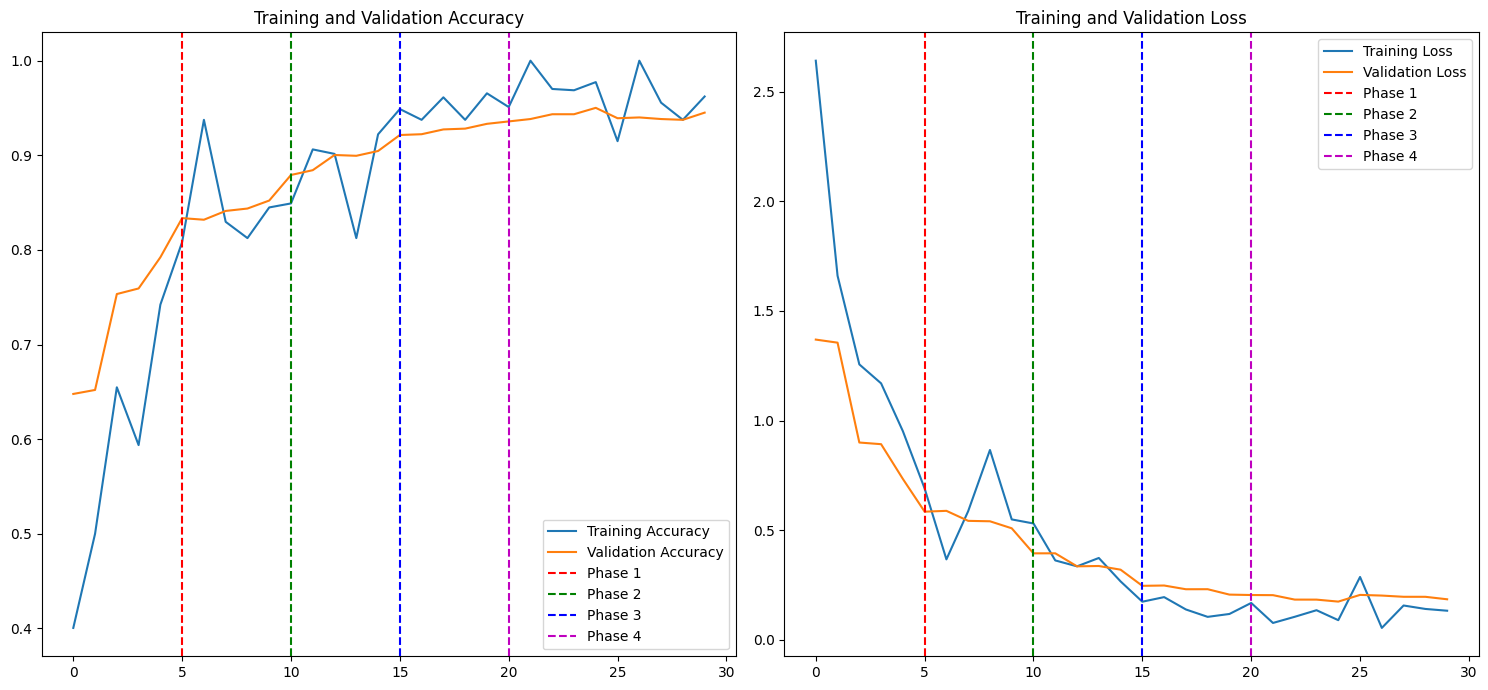


Analyzing which layers contain the strongest flower feature representations...
Analyzing layer: mixed0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Analyzing layer: mixed1
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step
Analyzing layer: mixed2
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Analyzing layer: mixed3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Analyzing layer: mixed4
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Analyzing layer: mixed5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Analyzing layer: mixed6
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Analyzing layer: mixed7
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Analyzing layer: mixed8
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Analyzing layer: mixed9_0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Analyzing layer: mixed9
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Analyzing layer: mixed9_1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Analyzing layer: mixed10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Layers ranked by activation strength (higher mean = stronger flower features):
1. mixed0: Mean=0.675856, Max=18.149286, Std=1.13

In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import cv2

# Setup directories
data_dir = "./data/flowers"
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print paths to verify
print(f"Training directory: {train_dir}")
print(f"Validation directory: {validation_dir}")
print(f"Test directory: {test_dir}")

# 1. Enhanced Data Augmentation for more robust feature learning
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,  # Many flowers look similar upside down
    brightness_range=[0.7, 1.3],
    fill_mode='reflect'  # Better for natural images
)

# Validation generator (no augmentation, just preprocessing)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Test generator (no augmentation, just preprocessing)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Set up parameters
img_height, img_width = 299, 299  # InceptionV3 input size
batch_size = 32

# Create training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Print number of classes and samples
print(f"Number of classes: {train_generator.num_classes}")
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

# Class indices mapping for reference
class_indices = train_generator.class_indices
print("\nClass mapping sample (first 10 classes):")
for i, (class_name, index) in enumerate(list(class_indices.items())[:10]):
    print(f"{index}: {class_name}")

# 2. Feature Visualization Functions
def preprocess_image(img_path, target_size=(299, 299)):
    """Load and preprocess an image for InceptionV3"""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def deprocess_image(img):
    """Convert preprocessed image back to displayable format"""
    img = img.reshape(img.shape[1:])
    img = (img + 1.0) * 127.5
    img = np.clip(img, 0, 255).astype('uint8')
    return img

# 3. Feature Diversity Loss - Encourages diverse feature activations in middle layers
def feature_diversity_loss(layer_output):
    """Loss function to encourage diverse feature activations"""
    # Calculate standard deviation across feature maps
    feature_std = K.std(layer_output, axis=-1)
    # Encourage higher standard deviation (more diverse features)
    return -K.mean(feature_std)

# 4. Class Activation Mapping
def generate_gradcam(model, img_array, layer_name, class_idx):
    """Generate Grad-CAM visualization for a specific class"""
    # Create a model that maps the input image to the activations of the specified layer and predictions
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]
        
    # Extract gradients
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0, 1))
    
    # Create a weighted combination of filters
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    
    # Process CAM
    cam = tf.maximum(cam, 0)
    cam = cam / tf.math.reduce_max(cam)
    cam = cam.numpy()
    return cam

def overlay_gradcam(img_path, cam, target_size=(299, 299)):
    """Overlay Grad-CAM heatmap on original image"""
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    
    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    overlayed = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)
    return overlayed

# 5. Custom Callback for Tracking Layer Activations
class FeatureVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, layer_names, output_dir='feature_viz', freq=2):
        super(FeatureVisualizationCallback, self).__init__()
        self.validation_data = validation_data
        self.layer_names = layer_names
        self.output_dir = output_dir
        self.freq = freq
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq != 0:
            return
            
        # Get a sample batch
        x_val, y_val = next(self.validation_data)
        
        # Create a model to output activations for each layer
        layer_outputs = [self.model.get_layer(name).output for name in self.layer_names]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        
        # Get activations
        activations = activation_model.predict(x_val)
        
        # Visualize activations for each layer
        for i, layer_name in enumerate(self.layer_names):
            # Create output directory for this layer
            layer_dir = os.path.join(self.output_dir, f"{layer_name}_epoch{epoch+1}")
            if not os.path.exists(layer_dir):
                os.makedirs(layer_dir)
                
            # Get layer activations
            layer_activation = activations[i]
            
            # Visualize feature maps
            plt.figure(figsize=(16, 16))
            features_per_row = 8
            n_features = min(64, layer_activation.shape[-1])
            n_rows = n_features // features_per_row
            
            for j in range(n_features):
                plt.subplot(n_rows, features_per_row, j+1)
                plt.imshow(layer_activation[0, :, :, j], cmap='viridis')
                plt.axis('off')
                
            plt.tight_layout()
            plt.savefig(os.path.join(layer_dir, f"feature_maps.png"))
            plt.close()
            
            # For the first sample image, also generate Grad-CAM for the top predicted class
            if i == len(self.layer_names) - 1:  # Only do this for the last layer
                predicted_class = np.argmax(self.model.predict(x_val[0:1]))
                cam = generate_gradcam(self.model, x_val[0:1], layer_name, predicted_class)
                
                # Reshape CAM to image dimensions
                cam_resized = cv2.resize(cam, (img_width, img_height))
                
                # Save CAM heatmap
                plt.figure(figsize=(8, 8))
                plt.imshow(cam_resized)
                plt.colorbar()
                plt.tight_layout()
                plt.savefig(os.path.join(layer_dir, f"gradcam_class{predicted_class}.png"))
                plt.close()

# 6. DeepDream Visualization Callback
def deepdream(model, img_array, layer_name, iterations=20, step=0.01):
    """Create a DeepDream image by maximizing activations"""
    # Create a model that outputs the target layer's activations
    feature_extractor = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    # Define the loss (maximize activations)
    def calculate_loss(img):
        activation = feature_extractor(img)
        return -tf.reduce_mean(activation)
    
    # Gradient ascent step
    @tf.function
    def gradient_ascent_step(img, learning_rate):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = calculate_loss(img)
        
        # Calculate gradients
        grads = tape.gradient(loss, img)
        # Normalize gradients
        grads = tf.math.l2_normalize(grads)
        # Apply gradients
        img += learning_rate * grads
        return loss, img
    
    # Start with the input image
    dream_img = tf.convert_to_tensor(img_array)
    
    # Perform gradient ascent
    for i in range(iterations):
        loss, dream_img = gradient_ascent_step(dream_img, step)
    
    # Return the final image
    return deprocess_image(dream_img.numpy())

class DeepDreamVisualizationCallback(keras.callbacks.Callback):
    def __init__(self, test_img_path, layers, output_dir='deepdream_viz', freq=5):
        super(DeepDreamVisualizationCallback, self).__init__()
        self.test_img = preprocess_image(test_img_path)
        self.layers = layers
        self.output_dir = output_dir
        self.freq = freq
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            # Save original image for reference
            original_img = image.load_img(test_img_path, target_size=(299, 299))
            original_img.save(os.path.join(output_dir, 'original_image.jpg'))
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq != 0:
            return
            
        epoch_dir = os.path.join(self.output_dir, f"epoch_{epoch+1}")
        if not os.path.exists(epoch_dir):
            os.makedirs(epoch_dir)
            
        for layer_name in self.layers:
            print(f"Generating DeepDream for layer {layer_name} at epoch {epoch+1}")
            try:
                # Generate DeepDream for this layer
                dream_img = deepdream(
                    self.model, 
                    self.test_img.copy(), 
                    layer_name,
                    iterations=15  # Keep it reasonably fast for monitoring
                )
                
                # Save visualization
                Image.fromarray(dream_img).save(os.path.join(epoch_dir, f"{layer_name}.jpg"))
            except Exception as e:
                print(f"Error generating DeepDream for layer {layer_name}: {e}")

# Initialize the base model
base_model = InceptionV3(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a final output layer with softmax for classification
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the main model
model = Model(inputs=base_model.input, outputs=predictions)

# Select a representative flower image for visualization
# You should replace this with an actual path to a flower image
sample_img_path = os.path.join(train_dir, os.listdir(train_dir)[0], os.listdir(os.path.join(train_dir, os.listdir(train_dir)[0]))[0])
print(f"Using sample image for visualizations: {sample_img_path}")

# Setup callbacks
monitor_layers = ['mixed3', 'mixed5', 'mixed7', 'mixed9']

feature_viz_callback = FeatureVisualizationCallback(
    validation_generator,
    monitor_layers,
    output_dir='feature_viz',
    freq=2
)

deepdream_callback = DeepDreamVisualizationCallback(
    sample_img_path,
    monitor_layers,
    output_dir='deepdream_viz',
    freq=5
)

# Regular training callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    'flower_model_checkpoint_{epoch:02d}.h5',
    save_best_only=True,
    monitor='val_accuracy'
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

callbacks = [
    feature_viz_callback,
    deepdream_callback,
    checkpoint_callback,
    reduce_lr_callback
]

# ----- TRAINING PROCESS -----

# STEP 1: Train only the top layers with all base model layers frozen
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("PHASE 1: Training top layers only...")
history_1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5,
    callbacks=callbacks
)

# STEP 2: Progressive Layer Unfreezing - One block at a time
# Get all the mixed layer names to use as reference points
mixed_layers = [layer.name for layer in base_model.layers if 'mixed' in layer.name]
mixed_layers.sort()  # Sort in ascending order from bottom to top

histories = [history_1]  # Keep track of training history

# Define the progressive unfreezing schedule - starting from the top
unfreezing_schedule = [
    mixed_layers[-1],  # mixed10
    mixed_layers[-2],  # mixed9
    mixed_layers[-3],  # mixed8
    mixed_layers[-4],  # mixed7
]

# Learning rate schedule - decrease as we unfreeze deeper layers
lr_schedule = [5e-4, 2e-4, 1e-4, 5e-5]

# Progressively unfreeze layers and train
for phase, (target_layer, lr) in enumerate(zip(unfreezing_schedule, lr_schedule), start=2):
    print(f"\nPHASE {phase}: Unfreezing layers from {target_layer} onwards...")
    
    # Reset all layers to trainable
    for layer in base_model.layers:
        layer.trainable = True
    
    # Then freeze everything before the target layer
    target_idx = [i for i, layer in enumerate(base_model.layers) if layer.name == target_layer][0]
    for layer in base_model.layers[:target_idx]:
        layer.trainable = False
        
    # Count trainable parameters
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    print(f"Trainable parameters: {trainable_count:,}")
    print(f"Non-trainable parameters: {non_trainable_count:,}")
    
    # Alternative approach for feature diversity: Use custom regularizer instead of multiple outputs
    if phase == 4:  # When we're unfreezing mixed7
        print("Adding feature diversity regularization for mid-level layers...")
        
        # Create a custom callback to monitor and encourage feature diversity
        class FeatureDiversityCallback(keras.callbacks.Callback):
            def __init__(self, layer_name='mixed7', weight=0.2):
                super(FeatureDiversityCallback, self).__init__()
                self.layer_name = layer_name
                self.weight = weight
                self.feature_model = None
                
            def on_train_begin(self, logs=None):
                self.feature_model = Model(
                    inputs=self.model.input,
                    outputs=self.model.get_layer(self.layer_name).output
                )
                
            def on_batch_end(self, batch, logs=None):
                if batch % 10 != 0:  # Only apply every 10 batches to save computation
                    return
                    
                # Get a batch of data
                x_batch, _ = next(train_generator)
                
                # Get layer activations
                with tf.GradientTape() as tape:
                    layer_output = self.feature_model(x_batch)
                    # Calculate diversity loss (negative std to maximize diversity)
                    diversity_loss = -K.mean(K.std(layer_output, axis=-1))
                    
                # Calculate gradients of the diversity loss with respect to weights
                trainable_weights = self.feature_model.trainable_weights
                gradients = tape.gradient(diversity_loss, trainable_weights)
                
                # Apply gradients with a smaller weight
                optimizer = self.model.optimizer
                diversity_weight = self.weight * optimizer.learning_rate
                
                # Manually update weights to increase feature diversity
                for w, g in zip(trainable_weights, gradients):
                    if g is not None:
                        new_w = w - diversity_weight * g
                        w.assign(new_w)
        
        # Add our custom feature diversity callback
        feature_diversity_cb = FeatureDiversityCallback(layer_name='mixed7', weight=0.2)
        phase_callbacks = callbacks + [feature_diversity_cb]
        
        # Compile with standard loss (no multiple outputs)
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        history_phase = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            epochs=5,
            callbacks=phase_callbacks
        )
    else:
        # Standard training for other phases
        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        history_phase = model.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.samples // batch_size,
            epochs=5,
            callbacks=callbacks
        )
    
    # Save history for plotting
    histories.append(history_phase)

# STEP 3: Final Fine-tuning Phase - All Layers
print("\nPHASE FINAL: Fine-tuning all layers with very low learning rate...")

# Make all layers trainable for final tuning
for layer in model.layers:
    layer.trainable = True

# Very low learning rate for final fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_final = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=5,
    callbacks=callbacks
)

histories.append(history_final)

# Save the final fine-tuned model
model.save('flower_finetuned_inceptionv3_enhanced.h5')

# Function to plot combined training history
def plot_training_history(histories):
    # Combined histories
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    
    # Combine histories - simplified since we're no longer using multiple outputs
    for history in histories:
        if 'accuracy' in history.history:
            acc.extend(history.history['accuracy'])
            val_acc.extend(history.history['val_accuracy'])
            loss.extend(history.history['loss'])
            val_loss.extend(history.history['val_loss'])
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.axvline(x=5, color='r', linestyle='--', label='Phase 1')
    plt.axvline(x=10, color='g', linestyle='--', label='Phase 2')
    plt.axvline(x=15, color='b', linestyle='--', label='Phase 3')
    plt.axvline(x=20, color='m', linestyle='--', label='Phase 4')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.axvline(x=5, color='r', linestyle='--', label='Phase 1')
    plt.axvline(x=10, color='g', linestyle='--', label='Phase 2')
    plt.axvline(x=15, color='b', linestyle='--', label='Phase 3')
    plt.axvline(x=20, color='m', linestyle='--', label='Phase 4')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.tight_layout()
    plt.savefig('enhanced_training_history.png')
    plt.show()

# Plot the training history
plot_training_history(histories)

# Function to analyze which layers contain the most flower-specific features
def analyze_flower_features(model, class_idx=None):
    """
    Analyzes model layers to find those with the strongest flower feature activations
    
    Parameters:
    - model: The trained model
    - class_idx: Optional specific flower class to analyze
    
    Returns:
    - Dictionary with layer rankings
    """
    # Get a few flower images
    flower_batch = next(train_generator)[0]
    
    # List of layers to analyze (focus on mixed layers)
    layers_to_analyze = [layer.name for layer in model.layers if 'mixed' in layer.name]
    
    # Store results
    layer_stats = {}
    
    # For each layer, measure activations
    for layer_name in layers_to_analyze:
        print(f"Analyzing layer: {layer_name}")
        layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        
        # Get activations for the batch
        activations = layer_model.predict(flower_batch)
        
        # Calculate statistics
        mean_activation = np.mean(activations)
        max_activation = np.max(activations)
        std_activation = np.std(activations)
        
        # Store results
        layer_stats[layer_name] = {
            'mean': float(mean_activation),
            'max': float(max_activation),
            'std': float(std_activation)
        }
    
    # Sort layers by mean activation (higher is better for feature representation)
    sorted_layers = sorted(layer_stats.items(), key=lambda x: x[1]['mean'], reverse=True)
    
    print("\nLayers ranked by activation strength (higher mean = stronger flower features):")
    for i, (layer_name, stats) in enumerate(sorted_layers):
        print(f"{i+1}. {layer_name}: Mean={stats['mean']:.6f}, Max={stats['max']:.6f}, Std={stats['std']:.6f}")
    
    return layer_stats

# Analyze which layers contain the most flower-specific features
print("\nAnalyzing which layers contain the strongest flower feature representations...")
layer_stats = analyze_flower_features(model)

print("\nTraining complete! Model saved as 'flower_finetuned_inceptionv3_enhanced.h5'")
print("This model has been optimized for strong flower feature representations across layers.")
print("For DeepDream, recommend using the top layers from the analysis above.")